In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt

In [2]:
conn = pg.connect("dbname=postgres user=postgres password=saude123")

In [137]:
uf_list = ['RO', 'CE', 'GO', 'RN', 'RJ', 'PA', 'MT', 'MA', 'ES', 'AM', 'PI', 'SP',
       'AL', 'DF', 'PE', 'PR', 'BA', 'SC', 'TO', 'SE', 'MS', 'MG', 'RS', 'AP',
       'PB', 'AC', 'RR']

# Null values over time analysis

In [215]:
daily_null_count = pd.read_sql_query('''
select * from
(
select * from
(
select "SG_UF_NOT" as uf,"DT_INTERNA" as date,count(*) as non_null from srag_bruto sb 
where "CARDIOPATI" is not null and "UTI" = 1
group by "SG_UF_NOT","DT_INTERNA"
) as t1
natural join
(
select "SG_UF_NOT" as uf, "DT_INTERNA" as date,count(*) as total from srag_bruto sb
where "UTI" = 1
group by "SG_UF_NOT","DT_INTERNA"
) as t2
) as t12
''', conn)

daily_null_count = daily_null_count[daily_null_count["date"].str[-4:].isin(["2020","2021","2022"])]
daily_null_count['date'] = pd.to_datetime(daily_null_count['date'])
daily_null_count.set_index('date', inplace = True)
df_dict_uf = {uf: daily_null_count[daily_null_count.uf == uf].join(other=dates.set_index('date'), how="right").fillna(0)
             for uf in uf_list}

for uf in uf_list:
    df_dict_uf[uf]['ratio'] = df_dict_uf[uf]['non_null']/df_dict_uf[uf]['total']
    df_dict_uf[uf].fillna(0,inplace=True)
    df_dict_uf[uf].sort_values('date',inplace=True)
    df_dict_uf[uf] = df_dict_uf[uf][df_dict_uf[uf].index > pd.to_datetime("2020-03-04")]

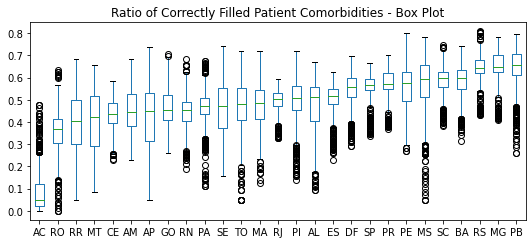

In [217]:
index = df_dict_uf["SP"].index
df = pd.DataFrame(index = index, data = {uf: df_dict_uf[uf]["ratio"].rolling(14).mean()
        for uf in uf_list})
df = pd.DataFrame(index = index, data = data).tail(727-21).interpolate().fillna(method = "bfill")
df = df[df.median().sort_values().index]


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True



ax = df.plot(kind='box', title='Ratio of Correctly Filled Patient Comorbidities - Box Plot')


plt.show()

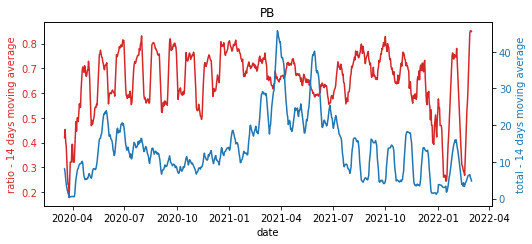

In [218]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('ratio - 14 days moving average', color=color)
ax1.plot(df_dict_uf["PB"]['ratio'].rolling(14).mean(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total - 14 days moving average', color=color)  # we already handled the x-label with ax1
ax2.plot(df_dict_uf["PB"]['total'].rolling(14).mean(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("PB")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Selecting Dates

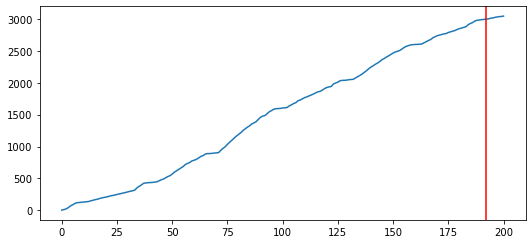

In [257]:
hospitalizations = pd.Series(range(1,201))
T = True
for d in range(1,201):
    iteration = df_dict_uf["PB"]
    hospitalizations[d] = iteration[iteration.index >= pd.to_datetime("2021-01-01")]["non_null"].head(d).sum()
    if hospitalizations[d] >= 3000 and T:
        T = False
        d3000 = d

plt.plot(hospitalizations)
plt.axvline(x = d3000, color = 'red')
plt.show()

In [258]:
d3000

192

# Importing Dataset

In [259]:
dataset = pd.read_sql_query('''
select * from srag_bruto sb 
where "SG_UF_NOT" = 'PB' and 
"CARDIOPATI" is not null and
"UTI" = 1
''', conn)
dataset = dataset[dataset['DT_INTERNA'].str[-4:].isin(["2020","2021","2022"])]
dataset['DT_INTERNA'] = pd.to_datetime(dataset['DT_INTERNA'])
dataset = dataset[(dataset['DT_INTERNA'] <= pd.to_datetime("2021-01-01") + pd.Timedelta(d3000,unit="D")) &
                 (dataset['DT_INTERNA'] >= pd.to_datetime("2021-01-01"))]
dataset.reset_index(drop = True, inplace = True)
dataset.head()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,DOSE_2_COV,DOSE_REF,FAB_COV_1,FAB_COV_2,FAB_COVREF,LOTE_REF,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV
0,18/01/2021,3,16/01/2021,2,PB,I NRS JOAO PESSOA,1377.0,SANTA RITA,251370,HOSPITAL METROPOLITANO DOM JOSE MARIA PIRES,...,None,None,None,None,None,None,None,None,None,NaN
1,02/05/2021,18,21/04/2021,16,PB,III NRS CAMPINA GRANDE,1421.0,CAMPINA GRANDE,250400,HOSPITAL MUNICIPAL PEDRO I COVID 19,...,None,None,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,None,None,None,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,210090,None,2.0
2,24/02/2021,8,10/02/2021,6,PB,I NRS JOAO PESSOA,1377.0,JOAO PESSOA,250750,HOSPITAL DE EMERGENCIA E TRAUMA SENADOR HUMBER...,...,04/06/2021,None,89 - COVID-19 ASTRAZENECA - CHADOX1-S,None,None,None,89 - COVID-19 ASTRAZENECA - CHADOX1-S,4120Z005,ABW4735,2.0
3,17/02/2021,7,02/02/2021,5,PB,VII NRS PIANCO,1423.0,PIANCO,251130,HOSPITAL WENCESLAU LOPES,...,None,None,None,None,None,None,None,None,None,NaN
4,25/03/2021,12,20/03/2021,11,PB,I NRS JOAO PESSOA,1377.0,SANTA RITA,251370,HOSPITAL METROPOLITANO DOM JOSE MARIA PIRES,...,None,None,None,None,None,None,None,None,None,1.0


In [260]:
cols = ['CARDIOPATI','HEMATOLOGI','SIND_DOWN',
        'HEPATICA','ASMA','DIABETES',
        'NEUROLOGIC','PNEUMOPATI','IMUNODEPRE',
        'RENAL','OBESIDADE']
for col in cols:
    dataset[col] = dataset[col].fillna(2).apply(lambda x: 1 if x == 1.0 else 0)

# Exporting Dataset

In [261]:
dataset.to_csv("data.csv")